In [1]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import contextily as ctx

using socrata to import the data from the two apis, can adjust the limits for valuation results when we have app_tokens and when we want to test our code on smaller/larger datasets (i think it has almost 10 million rows)

In [2]:
client = Socrata("data.cityofnewyork.us", '9llM0ejMVTKfRxS1XlvL7gXjU')

In [3]:
#first one is the property valuation and assessment dataset, need to update the limit for this as we go forward (there are 9 million+ entries)
vresults = client.get("yjxr-fw8i", content_type='geojson', limit=500000)
value_gdf = gpd.GeoDataFrame.from_features(vresults, crs='EPSG:4326')

#second one is the assessment actions dataset
aresults = client.get("4nft-bihw", content_type='json', limit=100000) 
actions_df = pd.DataFrame.from_records(aresults)

In [4]:
value_gdf.head()

geometry   nta   avland latitude    zip stories     avtot easement valtype  \
0     None  None     3310     None   None      31    159381     None   AC-TR   
1     None  None  1581750     None  10038    None   1581750     None   AC-TR   
2     None  None  2812050     None  10038       1   3696750     None   AC-TR   
3     None  None        0     None  10004       7         0     None   AC-TR   
4     None  None  9180000     None   None    None  11810700     None   AC-TR   

    exland  ... excd2         owner     extot    extot2  exland2  \
0     3310  ...  None  CHEN, QI TOM    159381    148953     3310   
1  1581750  ...  None      NYC DSBS   1581750   1080594  1080594   
2  2812050  ...  None      NYC DSBS   3696750   3487680  2812050   
3        0  ...  None          None         0      None     None   
4  9180000  ...  None      NYC DSBS  11810700  11142540  9180000   

  community_board borough period council_district ltdepth  
0            None    None  FINAL             None       0  
1            None    None  FINAL             None      52  
2            None    None  FINAL             None     500  
3            None    None  FINAL             None      73  
4            None    None  FINAL             None     604  

[5 rows x 40 columns]

In [5]:
#some of the data does not have geometry

In [6]:
actions_df.head()

borough_code block_number lot_number tax_year             owner_name  \
0            1            7         29     2017  SONS OF THE REVOLUTIO   
1            1            7         29     2018  SONS OF THE REVOLUTIO   
2            1            7         30     2017  SONS OF THE REVOLUTIO   
3            1            7         30     2018  SONS OF THE REVOLUTIO   
4            1            7         31     2017  FASHION MANAGMENT COR   

   property_address granted_reduction_amount tax_class_code  
0   26 WATER STREET                    34950              4  
1   26 WATER STREET                    23300              4  
2   24 WATER STREET                    55550              4  
3   24 WATER STREET                    36850              4  
4  105 BROAD STREET                    59450              4

plotting the property values one to see if the geodataframe worked

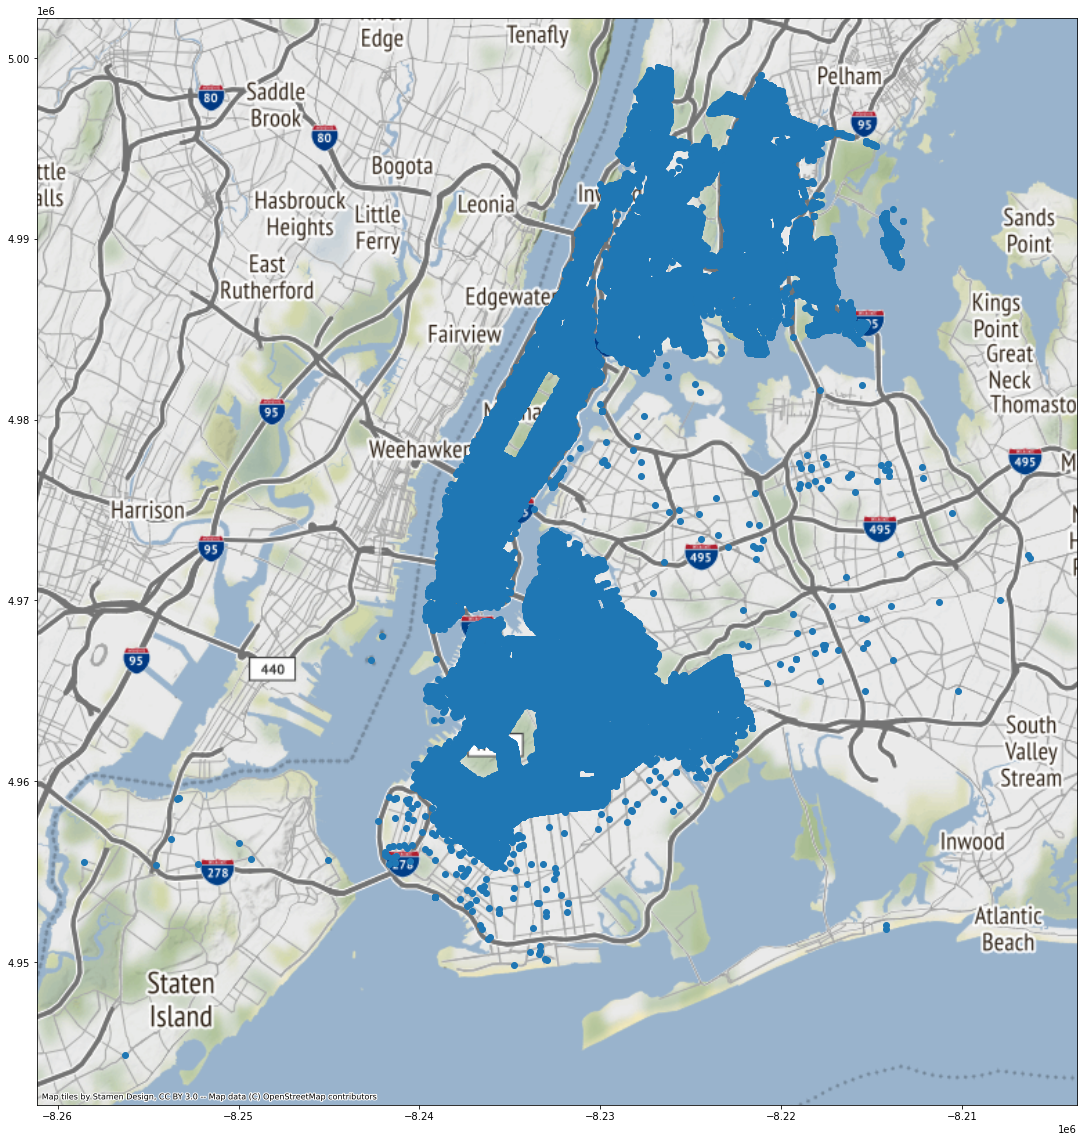

In [7]:
fig, ax = plt.subplots(figsize=(20,20))
value_gdf.to_crs('EPSG:3857').plot(ax=ax)
ctx.add_basemap(ax)

in order to combine the two datasets i made a new column in each that combines the borough, block, and lot numbers (keeping it as a string)

In [8]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
value_gdf['BBB']

0           1-16-3859
1             1-73-28
2             1-73-29
3           1-29-7504
4             1-36-12
             ...     
499995      3-5526-56
499996      3-5562-72
499997    3-5597-1013
499998    3-5656-1002
499999      3-5522-64
Name: BBB, Length: 500000, dtype: object

In [9]:
actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df['BBB']

0            1-7-29
1            1-7-29
2            1-7-30
3            1-7-30
4            1-7-31
            ...    
12316    5-72614-11
12317     5-72616-1
12318     5-72616-1
12319     5-72830-5
12320     5-72830-5
Name: BBB, Length: 12321, dtype: object

next i set the indexes in each to the new BBB identifiers

In [10]:
actions_df.set_index('BBB', inplace=True)
value_gdf.set_index('BBB', inplace=True)

then i joined them using an inner join to just get the results where both datasets had the same BBB

we should probably double check this going forward and see if we missed any properties

In [11]:
joined_gdf = value_gdf.join(actions_df, how='inner', rsuffix=('_actions'))

In [12]:
print('number of properties that overlap between the two datasets is '+str(len(joined_gdf)))
print('actions dataset length is '+str(len(actions_df)))
print('valuation dataset length is '+str(len(value_gdf)))

number of properties that overlap between the two datasets is 8818
actions dataset length is 12321
valuation dataset length is 500000


In [13]:
#checking the columns

In [14]:
joined_gdf.columns

Index(['geometry', 'nta', 'avland', 'latitude', 'zip', 'stories', 'avtot',
       'easement', 'valtype', 'exland', 'blddepth', 'year', 'taxclass',
       'longitude', 'bldfront', 'bldgcl', 'block', 'avtot2', 'excd1', 'bble',
       'staddr', 'exmptcl', 'avland2', 'census_tract', 'lot', 'boro',
       'ltfront', 'fullval', 'ext', 'bin', 'excd2', 'owner', 'extot', 'extot2',
       'exland2', 'community_board', 'borough', 'period', 'council_district',
       'ltdepth', 'borough_code', 'block_number', 'lot_number', 'tax_year',
       'owner_name', 'property_address', 'granted_reduction_amount',
       'tax_class_code'],
      dtype='object')

converting the granted reduction amount value to a numeric value so it can be plotted

In [15]:
joined_gdf['granted_reduction_amount']=pd.to_numeric(joined_gdf['granted_reduction_amount'])

plotting the properties that have been granted reductions with marker size based on the reduction amount

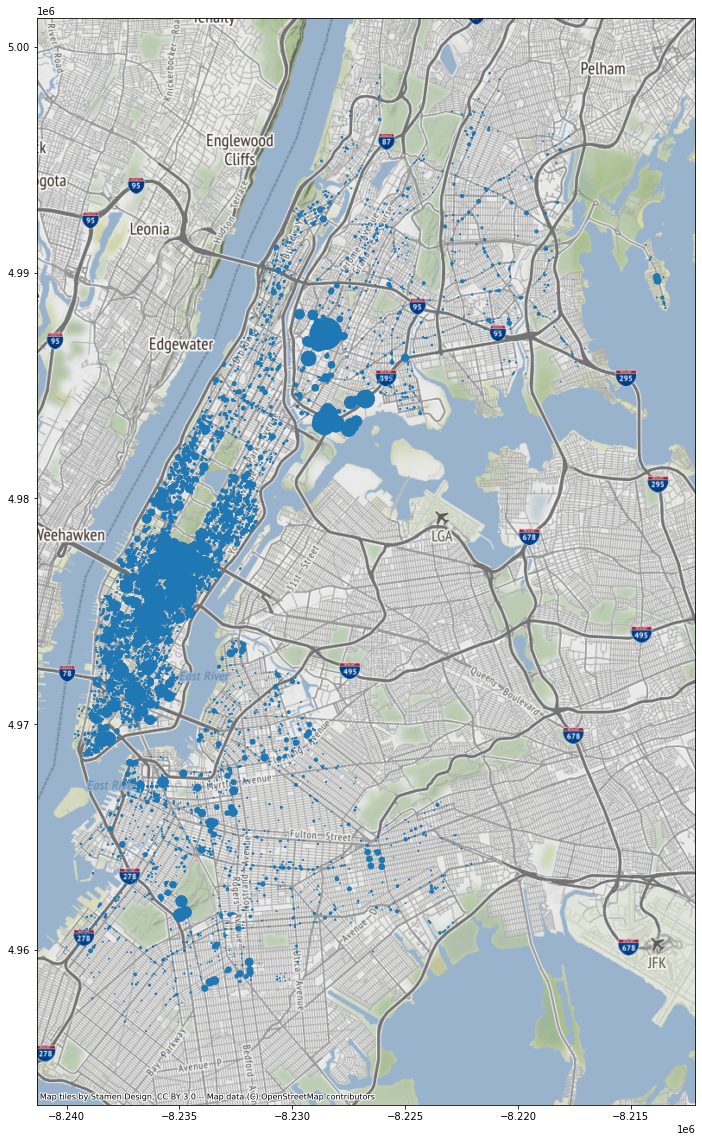

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
joined_gdf.to_crs('EPSG:3857').plot(ax=ax, markersize=joined_gdf['granted_reduction_amount']/100000) #had to scale down by 100000 so that one point wouldn't just cover the whole map
ctx.add_basemap(ax)

**going forward we need:**
- to increase the size of the valuation dataset that we use (by getting an app_token)
- to figure out how to better visualize the reductions in value (some of the values are super different than others and there are going to be a bunch of points). maybe we plot them by borough?
- maybe spatial join to tracts so that we can summarize the data by census tracts

## Census Data ##

In [17]:
#using cenpy to get ACS census tract data

In [18]:
from cenpy import products

#starting with median household income data
incomeDf = products.ACS(2017).from_place('New York City', level='tract',
                                        variables='B19019_001E')
incomeDf.rename(columns={'B19019_001E':'median_HH_income'}, inplace=True)
incomeDf.head()

/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/cenpy/products.py:791: UserWarning: Uncertain place identifier "New York City". The place identifier should look something like "placename, state" or, for larger areas, like Combined Statistical Areas or Metropolitan Statistical Areas,"placename1-placename2, state1-state2-state3"
  geoms, variables, *rest = super(ACS, self).from_place(
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be min

Matched: New York City to New York city within layer Incorporated Places


/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/jacobbasinger/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/xm/hhzqqkqx18z99mv99fltb_vm0000gq/T/ipykernel_81692/911789211.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  incomeDf = products.ACS

GEOID                                           geometry  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...   

   median_HH_income state county   tract  
0           91131.0    36    085  017012  
1           74630.0    36    085  014607  
2           80286.0    36    085  027706  
3          107589.0    36    085  014605  
4           56875.0    36    085  024700

In [19]:
incomeDf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2061 entries, 0 to 2060
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GEOID             2061 non-null   object  
 1   geometry          2061 non-null   geometry
 2   median_HH_income  2009 non-null   float64 
 3   state             2061 non-null   object  
 4   county            2061 non-null   object  
 5   tract             2061 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 112.7+ KB


<AxesSubplot:>

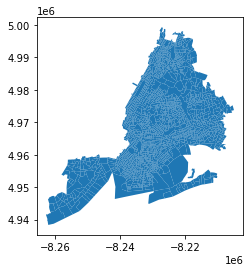

In [20]:
incomeDf.plot()

In [35]:
#using a spatial join to bring the point data for property values and reductions from above into the census tract dataset
sjoindf = incomeDf.sjoin(joined_gdf.to_crs("EPSG:3857"))
sjoindf.head()

GEOID                                           geometry  \
21  36047021000  POLYGON ((-8238993.960 4957725.950, -8238914.4...   
21  36047021000  POLYGON ((-8238993.960 4957725.950, -8238914.4...   
26  36047005100  POLYGON ((-8238290.090 4965792.380, -8238254.3...   
26  36047005100  POLYGON ((-8238290.090 4965792.380, -8238254.3...   
26  36047005100  POLYGON ((-8238290.090 4965792.380, -8238254.3...   

    median_HH_income state county   tract index_right  \
21           37623.0    36    047  021000   3-5764-27   
21           37623.0    36    047  021000   3-5764-27   
26           99792.0    36    047  005100  3-330-1316   
26           99792.0    36    047  005100    3-367-30   
26           99792.0    36    047  005100    3-335-45   

                                         nta  avland   latitude  ...  \
21                             Dyker Heights  198900  40.629513  ...   
21                             Dyker Heights  198900  40.629513  ...   
26  Carroll Gardens-Columbia Street-Red Hook     374  40.684887  ...   
26  Carroll Gardens-Columbia Street-Red Hook   31050  40.680769  ...   
26  Carroll Gardens-Columbia Street-Red Hook   34200  40.684664  ...   

   council_district ltdepth borough_code block_number lot_number tax_year  \
21               43     108            3         5764         27     2017   
21               43     108            3         5764         27     2018   
26               39     100            3          330       1316     2018   
26               39     100            3          367         30     2018   
26               39     100            3          335         45     2018   

               owner_name       property_address granted_reduction_amount  \
21  RALLIS FAMILY LIMITED  6717 FT HAMILTON PARK                   112650   
21  RALLIS FAMILY LIMITED  6717 FT HAMILTON PARK                   441200   
26  THE SUNFISH CONDOMINI     145 SACKETT STREET                     1910   
26      78-80 RAPELYE LLC      78 RAPELYE STREET                   349800   
26    97 UNION STREET LLC        97 UNION STREET                    79000   

   tax_class_code  
21              2  
21              2  
26              4  
26              4  
26              4  

[5 rows x 54 columns]

In [36]:
sjoindf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7680 entries, 21 to 2025
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   GEOID                     7680 non-null   object  
 1   geometry                  7680 non-null   geometry
 2   median_HH_income          7632 non-null   float64 
 3   state                     7680 non-null   object  
 4   county                    7680 non-null   object  
 5   tract                     7680 non-null   object  
 6   index_right               7680 non-null   object  
 7   nta                       7680 non-null   object  
 8   avland                    7680 non-null   object  
 9   latitude                  7680 non-null   object  
 10  zip                       7680 non-null   object  
 11  stories                   7484 non-null   object  
 12  avtot                     7680 non-null   object  
 13  easement                  4 non-null   

In [51]:
#making a new df with the total reduction amount granted per tract
tract_info = sjoindf.groupby('tract')[['granted_reduction_amount']].sum()
tract_info.head()

granted_reduction_amount
tract                           
000100                   3494438
000200                    456060
000201                     99350
000301                   6108482
000501                   4181024

In [52]:
#renaming the column to reflect that it's for the tract as a whole
tract_info.rename(columns={'granted_reduction_amount':'total_tract_reduction'}, inplace=True)

In [54]:
tract_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 632 entries, 000100 to 152200
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   total_tract_reduction  632 non-null    int64
dtypes: int64(1)
memory usage: 9.9+ KB


In [55]:
#joining the total reduction data back to the census df to be able to plot it by tract
tractjoin = incomeDf.join(tract_info, on='tract')

In [56]:
tractjoin.head()

GEOID                                           geometry  \
0  36085017012  POLYGON ((-8257822.870 4945745.990, -8257700.4...   
1  36085014607  POLYGON ((-8256547.370 4947814.750, -8256220.4...   
2  36085027706  POLYGON ((-8256097.640 4952157.350, -8255857.1...   
3  36085014605  POLYGON ((-8254991.570 4948209.800, -8254909.4...   
4  36085024700  POLYGON ((-8254048.590 4957893.610, -8253996.2...   

   median_HH_income state county   tract  total_tract_reduction  
0           91131.0    36    085  017012                    NaN  
1           74630.0    36    085  014607                    NaN  
2           80286.0    36    085  027706                    NaN  
3          107589.0    36    085  014605                    NaN  
4           56875.0    36    085  024700               345000.0

Text(0.5, 1.0, 'Total Reductions Granted Per Census Tract')

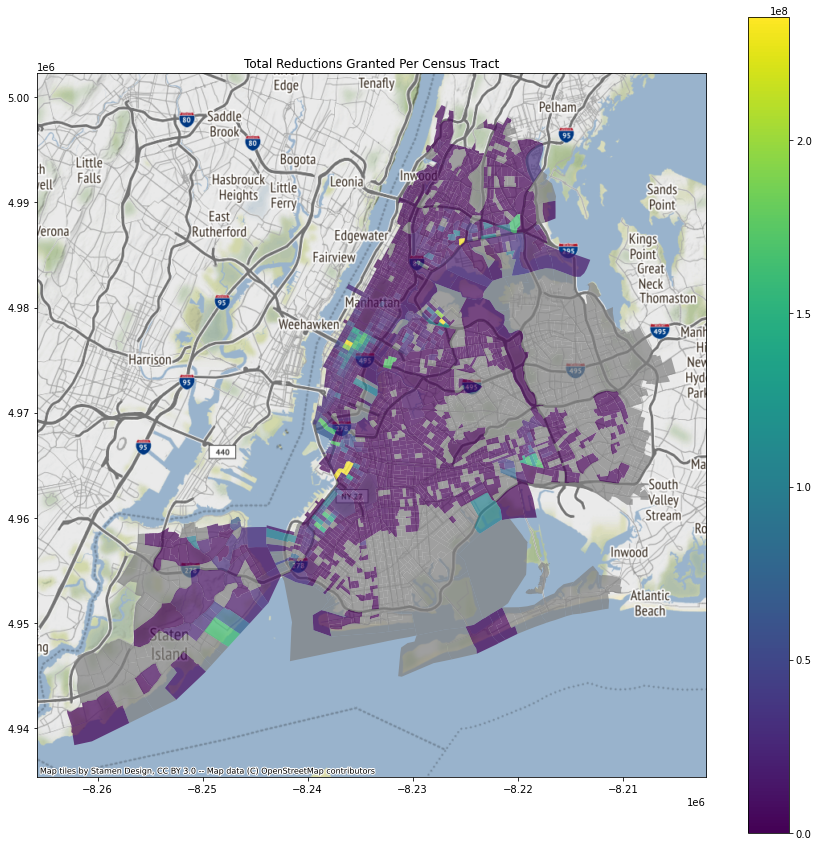

In [61]:
#plotting the total reduction granted per census tract to better visualize the distribution throughout NYC, with NaN values colored in as grey
fig, ax = plt.subplots(figsize=(15,15))
tractjoin.plot(column='total_tract_reduction', ax=ax, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax)
ax.set_title("Total Reductions Granted Per Census Tract")